In [ ]:
import numpy as np # linear algebra
import pandas as pd

In [ ]:
import os
import json

import albumentations as albu
import cv2
import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Input
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.losses import binary_crossentropy
from keras.callbacks import Callback, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Load Dataset


In [ ]:
train_df = pd.read_csv('/content/drive/My Drive/GIS_Cloud_Class/kaggle_dataset/train.csv',nrows=5000)
print(train_df.head())
train_df['ImageId'] = train_df['Image_Label'].apply(lambda x: x.split('_')[0])
train_df['ClassId'] = train_df['Image_Label'].apply(lambda x: x.split('_')[1])
train_df['hasMask'] = ~ train_df['EncodedPixels'].isna()
print(train_df["ClassId"])

          Image_Label                                      EncodedPixels
0    0011165.jpg_Fish  264918 937 266318 937 267718 937 269118 937 27...
1  0011165.jpg_Flower  1355565 1002 1356965 1002 1358365 1002 1359765...
2  0011165.jpg_Gravel                                                NaN
3   0011165.jpg_Sugar                                                NaN
4    002be4f.jpg_Fish  233813 878 235213 878 236613 878 238010 881 23...
0         Fish
1       Flower
2       Gravel
3        Sugar
4         Fish
         ...  
4995     Sugar
4996      Fish
4997    Flower
4998    Gravel
4999     Sugar
Name: ClassId, Length: 5000, dtype: object


In [ ]:
mask_count_df = train_df.groupby('ImageId').agg(np.sum).reset_index()
print(mask_count_df)
mask_count_df.sort_values('hasMask', ascending=False, inplace=True)


          ImageId  hasMask
0     0011165.jpg      2.0
1     002be4f.jpg      3.0
2     0031ae9.jpg      3.0
3     0035239.jpg      2.0
4     003994e.jpg      3.0
...           ...      ...
1245  3959204.jpg      2.0
1246  39612fc.jpg      3.0
1247  3967999.jpg      3.0
1248  39762aa.jpg      2.0
1249  397c2fd.jpg      1.0

[1250 rows x 2 columns]


In [ ]:
sub_df = pd.read_csv('/content/drive/My Drive/GIS_Cloud_Class/kaggle_dataset/sample_submission.csv',nrows=5000)
sub_df['ImageId'] = sub_df['Image_Label'].apply(lambda x: x.split('_')[0])
test_imgs = pd.DataFrame(sub_df['ImageId'].unique(), columns=['ImageId'])
print(sub_df.shape)
print(sub_df.head())

(5000, 3)
          Image_Label EncodedPixels      ImageId
0    002f507.jpg_Fish           1 1  002f507.jpg
1  002f507.jpg_Flower           1 1  002f507.jpg
2  002f507.jpg_Gravel           1 1  002f507.jpg
3   002f507.jpg_Sugar           1 1  002f507.jpg
4    0035ae9.jpg_Fish           1 1  0035ae9.jpg


In [ ]:
def np_resize(img, input_shape):
    """
    Reshape a numpy array, which is input_shape=(height, width), 
    as opposed to input_shape=(width, height) for cv2
    """
    height, width = input_shape
    return cv2.resize(img, (width, height))
    
def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle2mask(rle, input_shape):
    width, height = input_shape[:2]
    
    mask= np.zeros( width*height ).astype(np.uint8)
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
        
    return mask.reshape(height, width).T

def build_masks(rles, input_shape, reshape=None):
    depth = len(rles)
    if reshape is None:
        masks = np.zeros((*input_shape, depth))
    else:
        masks = np.zeros((*reshape, depth))
    
    for i, rle in enumerate(rles):
        if type(rle) is str:
            if reshape is None:
                masks[:, :, i] = rle2mask(rle, input_shape)
            else:
                mask = rle2mask(rle, input_shape)
                reshaped_mask = np_resize(mask, reshape)
                masks[:, :, i] = reshaped_mask
    
    return masks

def build_rles(masks, reshape=None):
    width, height, depth = masks.shape
    
    rles = []
    
    for i in range(depth):
        mask = masks[:, :, i]
        
        if reshape:
            mask = mask.astype(np.float32)
            mask = np_resize(mask, reshape).astype(np.int64)
        
        rle = mask2rle(mask)
        rles.append(rle)
        
    return rles


In [ ]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, df, target_df=None, mode='fit',
                 base_path='/content/drive/My Drive/GIS_Cloud_Class/kaggle_dataset/train_images',
                 batch_size=64, dim=(1400, 2100), n_channels=3, reshape=None,
                 augment=False, n_classes=4, random_state=2019, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.df = df
        self.mode = mode
        self.base_path = base_path
        self.target_df = target_df
        self.list_IDs = list_IDs
        self.reshape = reshape
        self.n_channels = n_channels
        self.augment = augment
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.random_state = random_state
        
        self.on_epoch_end()
        np.random.seed(self.random_state)

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_batch = [self.list_IDs[k] for k in indexes]
        
        X = self.__generate_X(list_IDs_batch)
        
        if self.mode == 'fit':
            y = self.__generate_y(list_IDs_batch)
            
            if self.augment:
                X, y = self.__augment_batch(X, y)
            
            return X, y
        
        elif self.mode == 'predict':
            return X

        else:
            raise AttributeError('The mode parameter should be set to "fit" or "predict".')
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.seed(self.random_state)
            np.random.shuffle(self.indexes)
    
    def __generate_X(self, list_IDs_batch):
        'Generates data containing batch_size samples'
        # Initialization
        if self.reshape is None:
            X = np.empty((self.batch_size, *self.dim, self.n_channels))
        else:
            X = np.empty((self.batch_size, *self.reshape, self.n_channels))
        
        # Generate data
        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['ImageId'].iloc[ID]
            img_path = f"{self.base_path}/{im_name}"
            img = self.__load_rgb(img_path)
            
            if self.reshape is not None:
                img = np_resize(img, self.reshape)
            
            # Store samples
            X[i,] = img

        return X
    
    def __generate_y(self, list_IDs_batch):
        if self.reshape is None:
            y = np.empty((self.batch_size, *self.dim, self.n_classes), dtype=int)
        else:
            y = np.empty((self.batch_size, *self.reshape, self.n_classes), dtype=int)
        
        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['ImageId'].iloc[ID]
            image_df = self.target_df[self.target_df['ImageId'] == im_name]
            
            rles = image_df['EncodedPixels'].values
            
            if self.reshape is not None:
                masks = build_masks(rles, input_shape=self.dim, reshape=self.reshape)
            else:
                masks = build_masks(rles, input_shape=self.dim)
            
            y[i, ] = masks

        return y
    
    def __load_grayscale(self, img_path):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = img.astype(np.float32) / 255.
        img = np.expand_dims(img, axis=-1)

        return img
    
    def __load_rgb(self, img_path):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32) / 255.

        return img
    
    def __random_transform(self, img, masks):
        composition = albu.Compose([
            albu.HorizontalFlip(),
            albu.VerticalFlip(),
            albu.ShiftScaleRotate(rotate_limit=30, shift_limit=0.1)
        ])
        
        composed = composition(image=img, mask=masks)
        aug_img = composed['image']
        aug_masks = composed['mask']
        
        return aug_img, aug_masks
    
    def __augment_batch(self, img_batch, masks_batch):
        for i in range(img_batch.shape[0]):
            img_batch[i, ], masks_batch[i, ] = self.__random_transform(
                img_batch[i, ], masks_batch[i, ])
        
        return img_batch, masks_batch

In [ ]:
def build_model(input_shape):
    inputs = Input(input_shape)

    c1 = Conv2D(8, (3, 3), activation='elu', padding='same') (inputs)
    c1 = Conv2D(8, (3, 3), activation='elu', padding='same') (c1)
    p1 = MaxPooling2D((2, 2), padding='same') (c1)

    c2 = Conv2D(16, (3, 3), activation='elu', padding='same') (p1)
    c2 = Conv2D(16, (3, 3), activation='elu', padding='same') (c2)
    p2 = MaxPooling2D((2, 2), padding='same') (c2)

    c3 = Conv2D(32, (3, 3), activation='elu', padding='same') (p2)
    c3 = Conv2D(32, (3, 3), activation='elu', padding='same') (c3)
    p3 = MaxPooling2D((2, 2), padding='same') (c3)

    c4 = Conv2D(64, (3, 3), activation='elu', padding='same') (p3)
    c4 = Conv2D(64, (3, 3), activation='elu', padding='same') (c4)
    p4 = MaxPooling2D((2, 2), padding='same') (c4)

    c5 = Conv2D(64, (3, 3), activation='elu', padding='same') (p4)
    c5 = Conv2D(64, (3, 3), activation='elu', padding='same') (c5)
    p5 = MaxPooling2D((2, 2), padding='same') (c5)

    c55 = Conv2D(128, (3, 3), activation='elu', padding='same') (p5)
    c55 = Conv2D(128, (3, 3), activation='elu', padding='same') (c55)

    u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c55)
    u6 = concatenate([u6, c5])
    c6 = Conv2D(64, (3, 3), activation='elu', padding='same') (u6)
    c6 = Conv2D(64, (3, 3), activation='elu', padding='same') (c6)

    u71 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
    u71 = concatenate([u71, c4])
    c71 = Conv2D(32, (3, 3), activation='elu', padding='same') (u71)
    c61 = Conv2D(32, (3, 3), activation='elu', padding='same') (c71)

    u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c61)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(32, (3, 3), activation='elu', padding='same') (u7)
    c7 = Conv2D(32, (3, 3), activation='elu', padding='same') (c7)

    u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(16, (3, 3), activation='elu', padding='same') (u8)
    c8 = Conv2D(16, (3, 3), activation='elu', padding='same') (c8)

    u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(8, (3, 3), activation='elu', padding='same') (u9)
    c9 = Conv2D(8, (3, 3), activation='elu', padding='same') (c9)

    outputs = Conv2D(4, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [ ]:
BATCH_SIZE = 32

train_idx, val_idx = train_test_split( mask_count_df.index, random_state=2019, test_size=0.2)

In [ ]:

train_generator = DataGenerator(
    train_idx, 
    df=mask_count_df,
    target_df=train_df,
    batch_size=BATCH_SIZE,
    reshape=(320, 480),
    augment=True,
    n_channels=3,
    n_classes=4)


In [ ]:

val_generator = DataGenerator(
    val_idx, 
    df=mask_count_df,
    target_df=train_df,
    batch_size=BATCH_SIZE, 
    reshape=(320, 480),
    augment=False,
    n_channels=3,
    n_classes=4)

In [ ]:
model = build_model((320, 480, 3))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 320, 480, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 320, 480, 8)  224         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 320, 480, 8)  584         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 160, 240, 8)  0           conv2d_2[0][0]                   
____________________________________________________________________________________________

In [ ]:
checkpoint = ModelCheckpoint('/content/drive/My Drive/GIS_Cloud_Class/kaggle_dataset/model/model_5000.h5',verbose=1, monitor='val_acc', save_best_only=True)
history = model.fit_generator(train_generator,
                              validation_data=val_generator,
                              callbacks=[checkpoint],
                              epochs=30,verbose = 1)
model.save_weights('/content/drive/My Drive/GIS_Cloud_Class/kaggle_dataset/model/model_checkpoint_5000')


Epoch 1/30


/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 14 could not be retrieved. It could be because a worker has died.
  UserWarning)


 9/31 [=======>......................] - ETA: 3:03 - loss: 0.6687 - accuracy: 0.5741

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 28 could not be retrieved. It could be because a worker has died.
  UserWarning)


11/31 [=========>....................] - ETA: 3:53 - loss: 0.6574 - accuracy: 0.5912

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 17 could not be retrieved. It could be because a worker has died.
  UserWarning)


15/31 [=============>................] - ETA: 3:15 - loss: 0.6360 - accuracy: 0.6201

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 19 could not be retrieved. It could be because a worker has died.
  UserWarning)


25/31 [=======================>......] - ETA: 1:01 - loss: 0.5977 - accuracy: 0.6670

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 25 could not be retrieved. It could be because a worker has died.
  UserWarning)


31/31 [==============================] - 312s 10s/step - loss: 0.5806 - accuracy: 0.6996 - val_loss: 0.5030 - val_accuracy: 0.8396
Epoch 2/30


/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


31/31 [==============================] - 105s 3s/step - loss: 0.4680 - accuracy: 0.8430 - val_loss: 0.4558 - val_accuracy: 0.8407
Epoch 3/30
31/31 [==============================] - 105s 3s/step - loss: 0.4384 - accuracy: 0.8444 - val_loss: 0.4315 - val_accuracy: 0.8411
Epoch 4/30
31/31 [==============================] - 106s 3s/step - loss: 0.4290 - accuracy: 0.8445 - val_loss: 0.4275 - val_accuracy: 0.8415
Epoch 5/30
31/31 [==============================] - 109s 4s/step - loss: 0.4265 - accuracy: 0.8447 - val_loss: 0.4235 - val_accuracy: 0.8419
Epoch 6/30
31/31 [==============================] - 109s 4s/step - loss: 0.4231 - accuracy: 0.8453 - val_loss: 0.4280 - val_accuracy: 0.8419
Epoch 7/30
31/31 [==============================] - 111s 4s/step - loss: 0.4203 - accuracy: 0.8448 - val_loss: 0.4153 - val_accuracy: 0.8419
Epoch 8/30
31/31 [==============================] - 108s 3s/step - loss: 0.4194 - accuracy: 0.8448 - val_loss: 0.4177 - val_accuracy: 0.8419
Epoch 9/30
31/31 [======

In [ ]:
model.load_weights('/content/drive/My Drive/GIS_Cloud_Class/kaggle_dataset/model/model_checkpoint_5000')

In [ ]:
test_df = []

for i in range(0, test_imgs.shape[0], 500):
    batch_idx = list(
        range(i, min(test_imgs.shape[0], i + 500)))

    test_generator = DataGenerator(
        batch_idx,
        df=test_imgs,
        shuffle=False,
        mode='predict',
        dim=(350, 525),
        reshape=(320, 480),
        n_channels=3,
        base_path='/content/drive/My Drive/GIS_Cloud_Class/kaggle_dataset/test_images',
        target_df=sub_df,
        batch_size=1,
        n_classes=4)

    batch_pred_masks = model.predict_generator(
        test_generator, 
        workers=1,
        verbose=1)

    for j, b in enumerate(batch_idx):
        filename = test_imgs['ImageId'].iloc[b]
        image_df = sub_df[sub_df['ImageId'] == filename].copy()

        pred_masks = batch_pred_masks[j, ].round().astype(int)
        pred_rles = build_rles(pred_masks, reshape=(350, 525))
        image_df['EncodedPixels'] = pred_rles
        test_df.append(image_df)

test_df = pd.concat(test_df)
test_df.drop(columns='ImageId', inplace=True)
test_df.to_csv('/content/drive/My Drive/GIS_Cloud_Class/kaggle_dataset/gravel_submission_5000.csv', index=False)

250/250 [==============================] - 86s 345ms/step


In [ ]:
def pixels2masks(path):
  #create masks from encoded pixels
  pred_df = pd.read_csv(path,nrows=25)
  #print(pred_df)
  plt.figure(figsize=(50,50))
  for k in range(pred_df.shape[0]):
    enc_pixels = pred_df["EncodedPixels"][k]
    #enc_pixels = list(enc_pixels)
    #enc_pixels = enc_pixels[0]
    #print(type(enc_pixels))
    if isinstance(enc_pixels, float):
      continue
    enc_pixels = enc_pixels.split(" ")
    #print(enc_pixels)
    pixels = list()
    for i in range(0,len(enc_pixels),2):
      x = int(enc_pixels[i])
      count = int(enc_pixels[i+1])
      for j in range(count):
        pixels.append(x-1)
        x+=1

    img_id = pred_df["Image_Label"][k].split("_")[0]
    mask_id = pred_df["Image_Label"][k]
    path = "/content/drive/My Drive/GIS_Cloud_Class/kaggle_dataset/test_images/"
    img_location = path+img_id
    img = cv2.resize(cv2.imread(img_location), (525, 350))
    #print(img.shape)
    #plt.imshow(img)
    mask_img = np.zeros((350*525,1), dtype=int)
    mask_img[pixels] = 255
    l,b=img.shape[0], img.shape[1]
    mask = np.reshape(mask_img, (b, l)).T
    #print(mask_img)

    plt.subplot(pred_df.shape[0], 2,2*k+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img)
    
    plt.subplot(pred_df.shape[0], 2,2*k+2)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(mask)


    cv2.imwrite("/content/drive/My Drive/GIS_Cloud_Class/kaggle_dataset/model/mask_preds/mask_"+str(mask_id), mask)

  plt.tight_layout()
  plt.show()

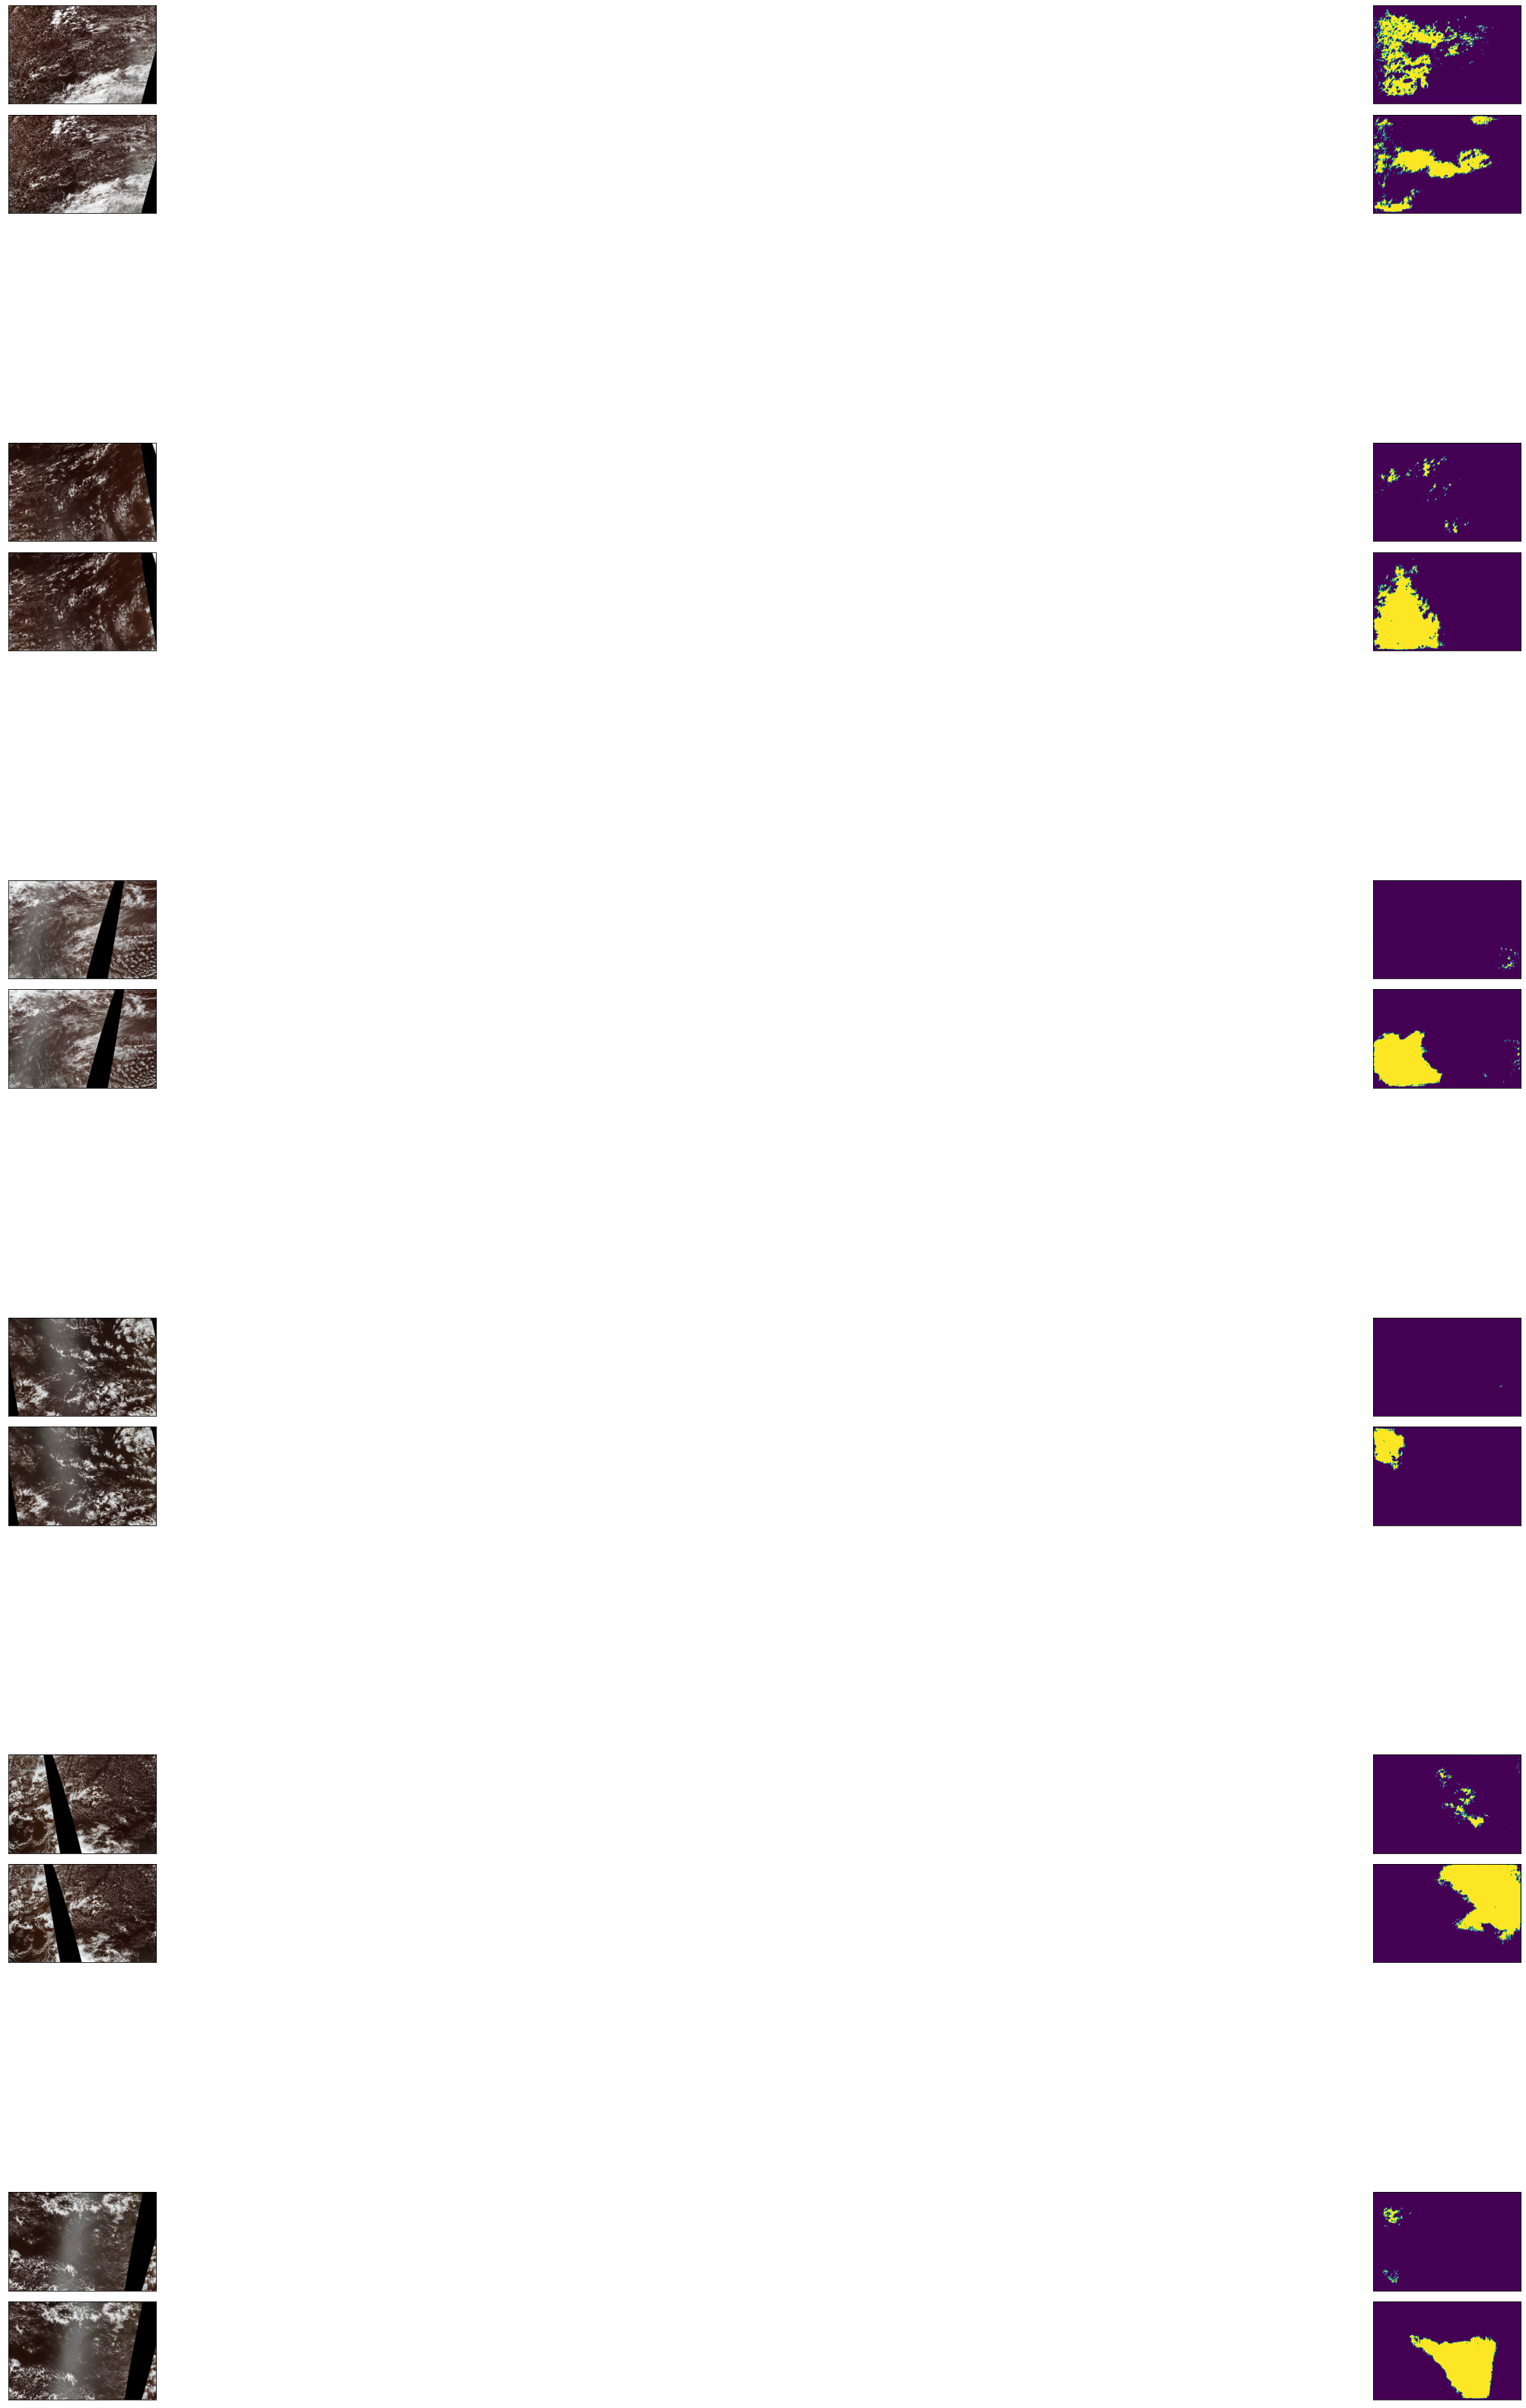

In [ ]:
path = '/content/drive/My Drive/GIS_Cloud_Class/kaggle_dataset/flower_submission_5000.csv'
pixels2masks(path)

#cv2.imwrite('/content/drive/My Drive/GIS_Cloud_Class/kaggle_dataset/mode/pred_mask.png',mask)

In [ ]:
results = model.evaluate(x_test, y_test, batch_size=32)

In [ ]:
from google.colab.patches import cv2_imshow
for k in range(test_df.shape[0]):
  temp1 = cv2.imread("/content/drive/My Drive/GIS_Cloud_Class/kaggle_dataset/test_images/"+test_df['Image_Label'][k].split('_')[0])
  temp2 = rle2mask(test_df['EncodedPixels'][k],temp1.shape)
  temp3 = np.zeros([temp2.shape[0],temp2.shape[1],3])
  for i in range(temp2.shape[0]):
    for j in range(temp2.shape[1]):
      if(temp2[i,j]==1):
        temp3[i,j]=[0,0,0]
      elif(temp2[i,j]==0):
        temp3[i,j]=[255,255,255]
  print(temp3.shape)
  cv2.imwrite("/content/drive/My Drive/GIS_Cloud_Class/kaggle_dataset/model/newImage"+str(k)+".png",temp3)
  cv2.imwrite("/content/drive/My Drive/GIS_Cloud_Class/kaggle_dataset/model/newImage_test"+str(k)+".png",temp1)
  #cv2_imshow(temp3)
      #"/content/drive/My Drive/GIS_Cloud_Class/kaggle_dataset/model/newImage_test"+str(i)+".png",temp1)